In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import csv

%matplotlib inline
plt.rcParams['axes.linewidth'] = 2

Reading the data here. The Kaggle page does not provide documentation, so cleaning will require some guessing and assumptions. 

In [31]:
df = pd.read_csv("data/us_perm_visas.csv", 
                 low_memory=False, 
                 parse_dates=True,
                 true_values=["Y"],
                 false_values=["N"])
print(df.shape)

(374362, 154)


First, check the state of the outcome variable.

In [32]:
df.case_status.value_counts(dropna=False)

Certified            181933
Certified-Expired    148586
Denied                25649
Withdrawn             18194
Name: case_status, dtype: int64

Good to see no missing observations. I want to conduct a binary classification between certified and denied cases. So I'll remove expired and withdrawn.

In [33]:
classifier = (df['case_status'] == 'Certified') | (df['case_status'] == 'Denied')
df = df[classifier]
df.case_status.value_counts(dropna=False)

Certified    181933
Denied        25649
Name: case_status, dtype: int64

Some other minor adjustments that I discovered needed to be made as I looked through the data.

In [34]:
# remove small # (<50) cases where wage not entered annually
yearly = df['pw_unit_of_pay_9089']== 'Year'
df = df[yearly]

#combine two columns for citizenship.
df['country_of_citizenship'] = df.country_of_citizenship.fillna('')
df['country_of_citzenship'] = df.country_of_citzenship.fillna('')
citizenship = df['country_of_citizenship'] + df['country_of_citzenship']
df['citizenship'] = citizenship

#combine two columns for job title
df['add_these_pw_job_title_9089'] = df.add_these_pw_job_title_9089.fillna('')
df['pw_job_title_9089'] = df.pw_job_title_9089.fillna('')
job_title = df['pw_job_title_9089'] + df['add_these_pw_job_title_9089']
df['job_title'] = job_title

#drop excess columns
df = df.drop(['country_of_citizenship', 'country_of_citzenship', 'add_these_pw_job_title_9089', 'pw_job_title_9089'], axis = 1)

#select h_1b work visa applications
h_1b = df['class_of_admission']=='H-1B'
df = df[h_1b]

Now I check on the missing values situation. How bad is it? Here I create a histogram of missing values across columns. This helps me see how many columns have problems.

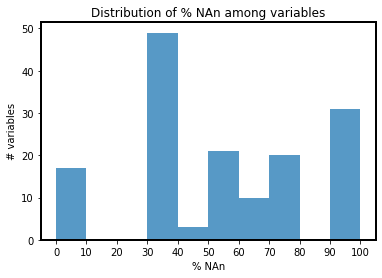

In [35]:
pct_na = (df.drop('case_status', 1).isna().sum() /df.shape[0]) * 100

counts, bins, patches = plt.hist(pct_na, 10, alpha = 0.75)

plt.xticks(np.arange(0, 101, 10))
plt.title('Distribution of % NAn among variables')
plt.xlabel('% NAn')
plt.ylabel('# variables')
plt.show()

Looks pretty bad. Vast majority of columns missing more than 30% of data. I try visualizing missing values across columns from a subsample of the data:

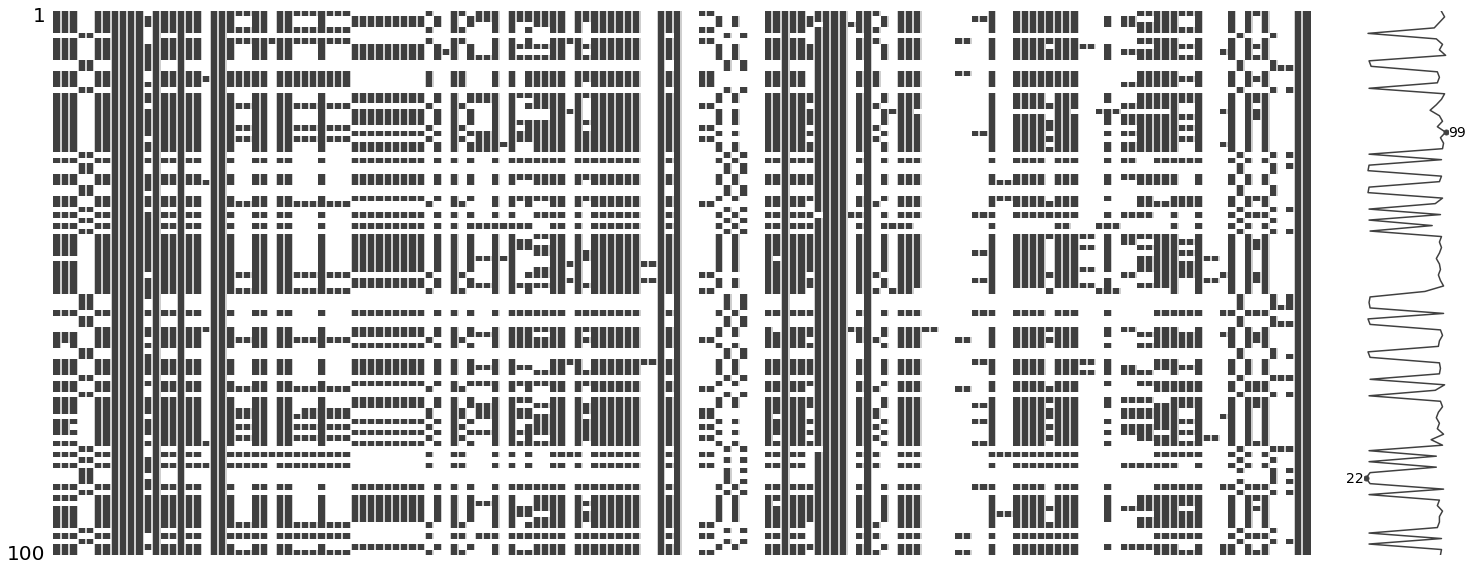

In [36]:
msno.matrix(df.sample(100))
plt.show()

There's certainly a lot missing, but it seems to follow a pattern. To try and figure out the pattern I'll sort rows of the dataset by number of missing values. 

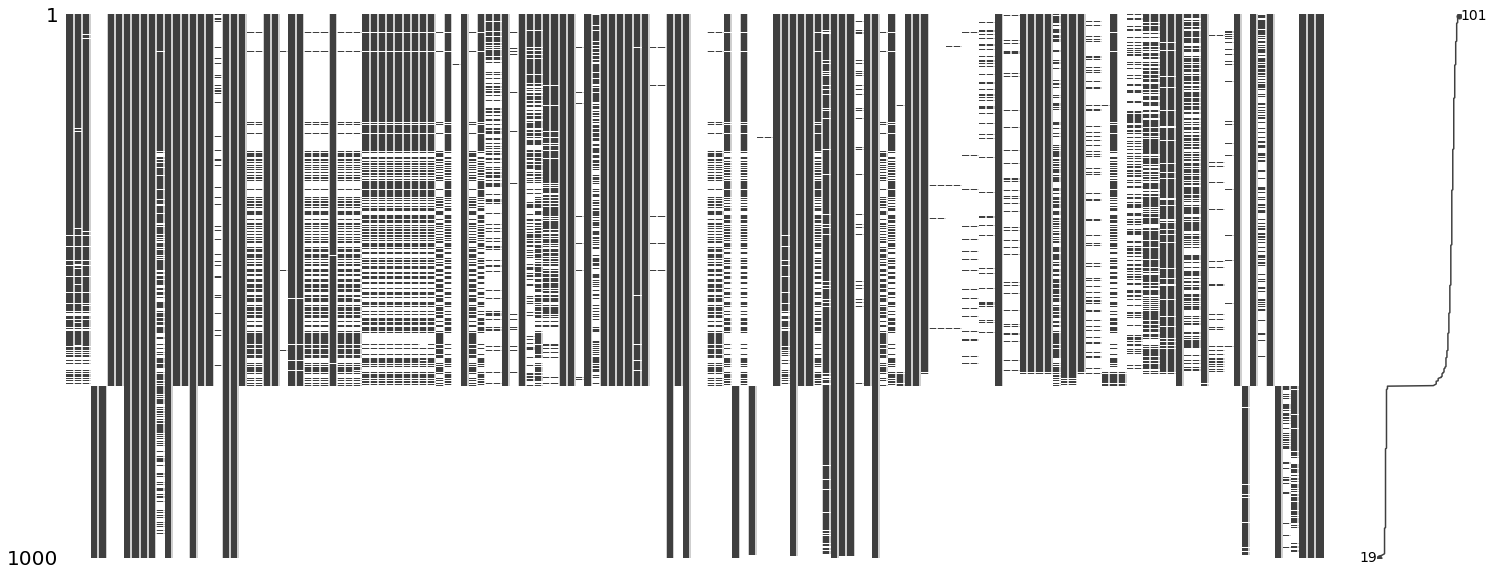

In [37]:
df_sample = df.sample(1000)
df_sample['null_count'] = df_sample.isnull().sum(axis=1)
df_sample = df_sample.sort_values(by = 'null_count')

msno.matrix(df_sample)
plt.show()

That definitely worked. Seems like about a third of the observations is missing almost all of its information. I'll zoom in on the first few columns, which contain more general info about the application, to try and identify why this is happening. 

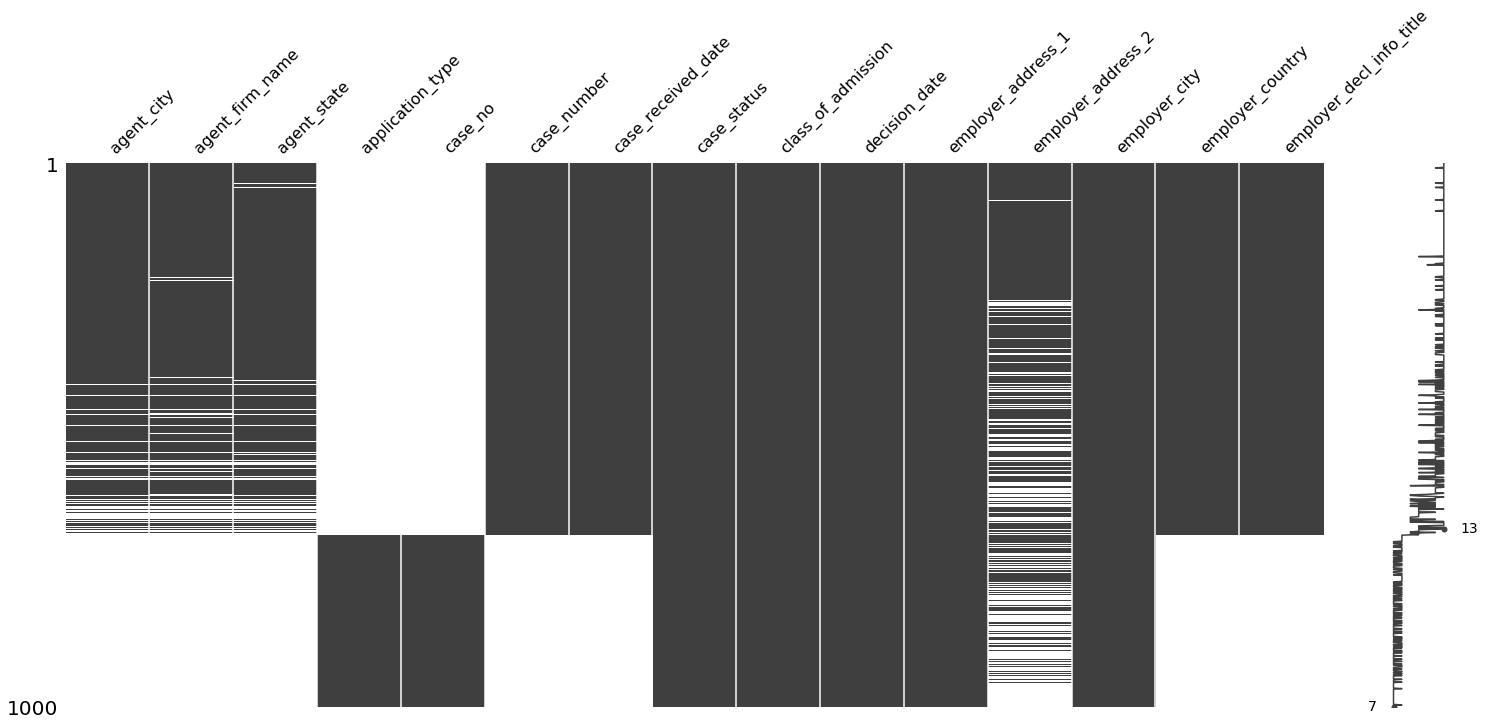

In [38]:
msno.matrix(df_sample.iloc[ : , 0:15])
plt.show()

Looks like the observations split into two groups. The first group has agents listed, while the second has an application type. I'll check the options for application type to look for hints about the logistics behind this distinction. 

In [39]:
df['application_type'].value_counts()

ONLINE      45877
MAILEDIN      365
Name: application_type, dtype: int64

I cannot say for certain without detailed documentation, but it seems like these applicants may have applied for their visa independently without an agent. It is certainly worth exploring whether these two groups have different certification likelihoods. For now, I will move forward looking only at the agent applications, since these have so much more information to use in prediction. 

TODO: Compare the two apparent application types. 

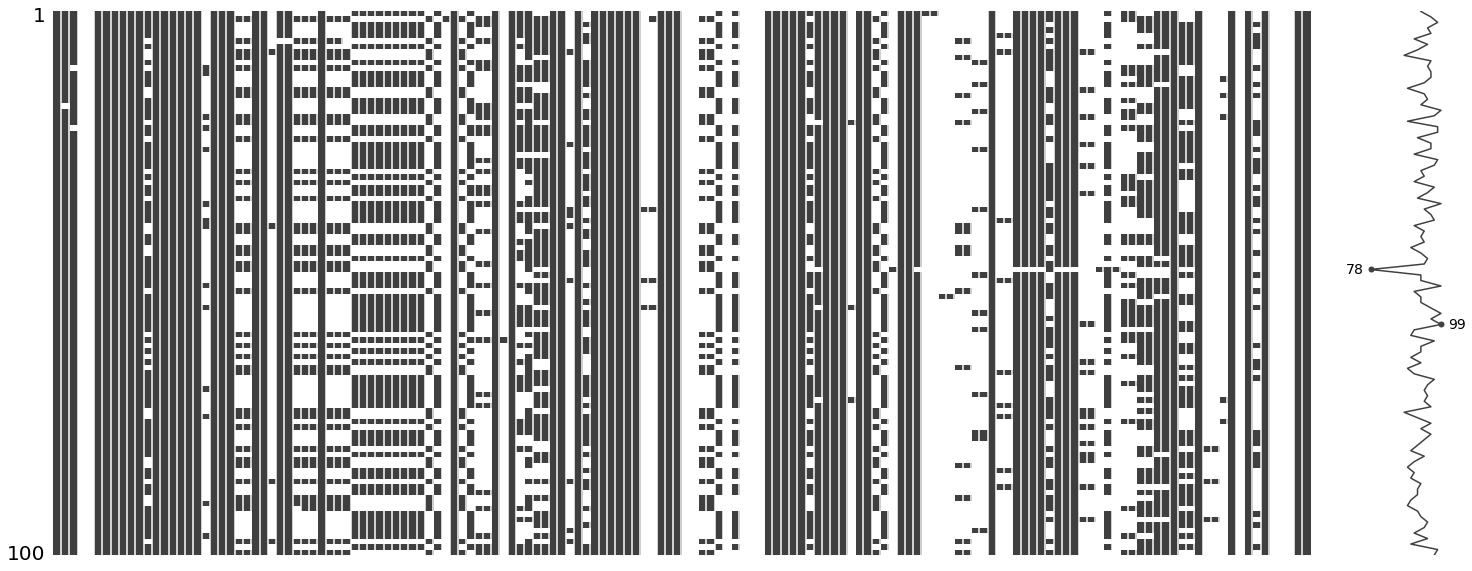

In [41]:
agent = pd.notnull(df['agent_firm_name']) | pd.notnull(df['agent_city']) | pd.notnull(df['agent_state'])
df = df[agent]

msno.matrix(df.sample(100))
plt.show()

Isolating applications made through agents makes the data look less sparse. Next, I'll get rid of empty columns.

(84399, 114)


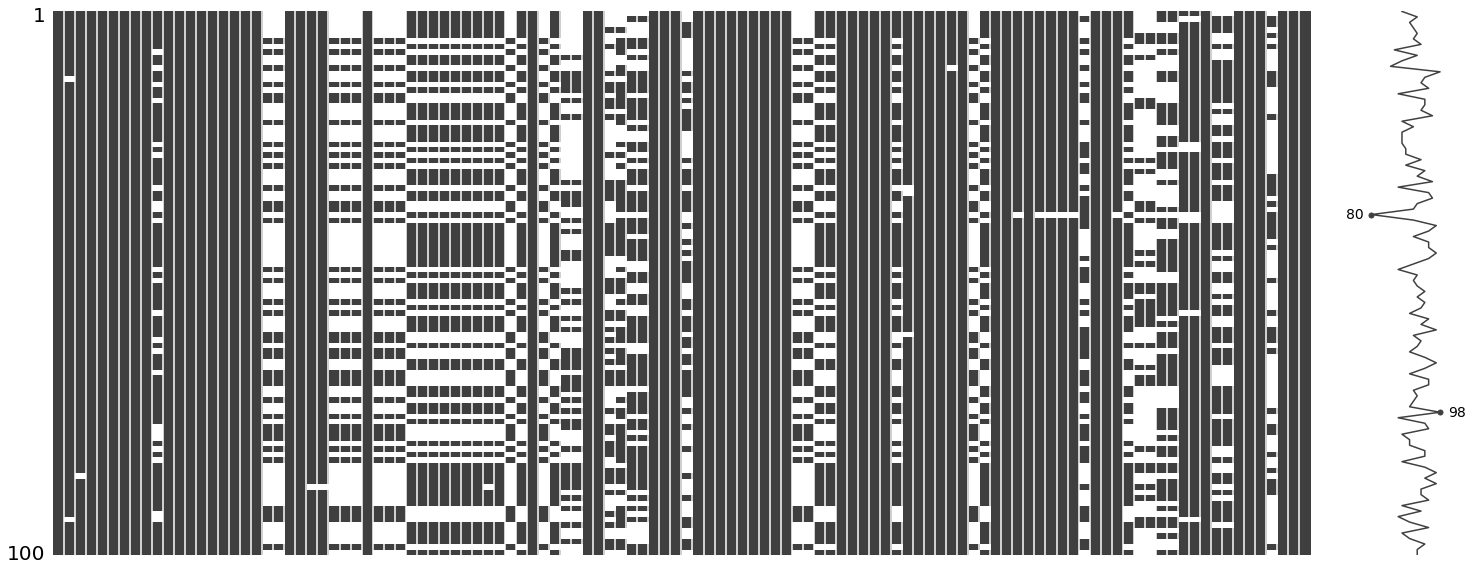

In [43]:
df = df[df.columns[df.isnull().mean() < 0.8]]
print(df.shape)

msno.matrix(df.sample(100))
plt.show()

Now looking quite good. Just on the left of the above matrix, it looks like there are still some patterns emerging. I looked at the columns in this region and found that variables containing information about the applicant's background had been split into two sets with different variable names. I could not easily identify what differentiated the two sets. Further, one set was missing some variables, like education. So I decided to filter it out and look only at the other set.

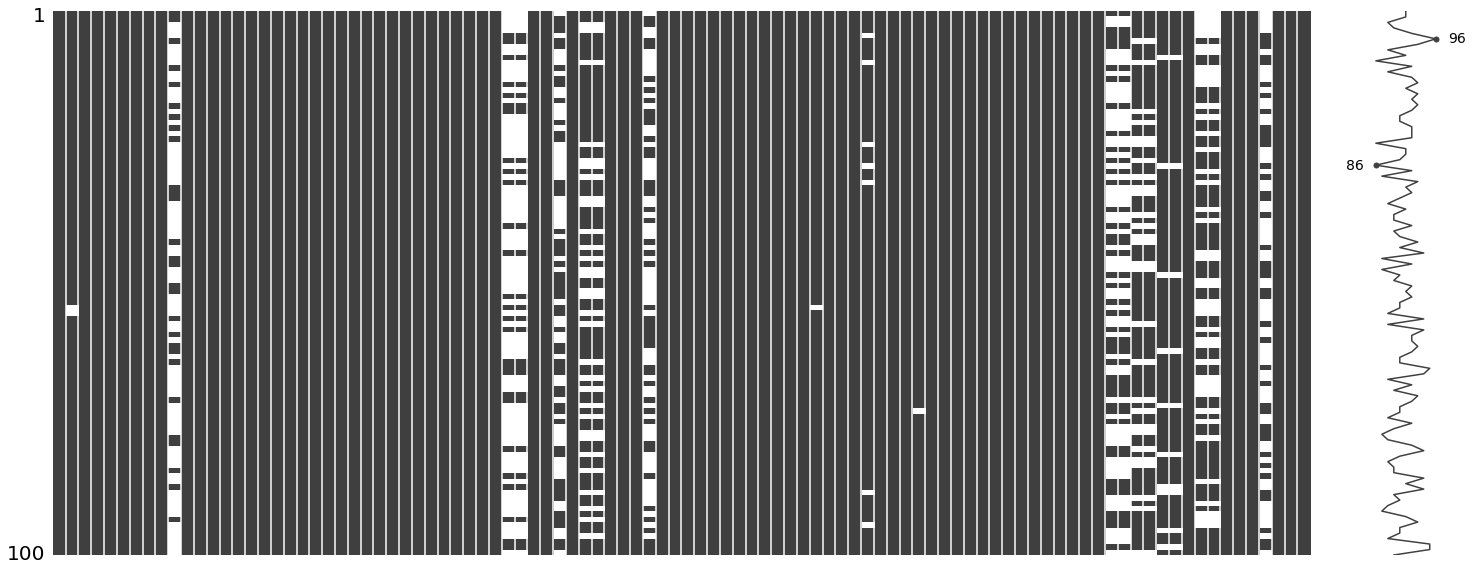

(29278, 98)


In [44]:
foreign_worker = pd.notnull(df['foreign_worker_info_alt_edu_experience'])
df = df[foreign_worker]
df = df[df.columns[df.isnull().mean() < 0.8]]
msno.matrix(df.sample(100))
plt.show()
print(df.shape)

Now I've narrowed down to the set of observations about which I have the most information. 

It's less than 10% of the original sample. I should be cautious about interpreting my results. I have identified two instances of systematically missing data that I cannot really explain. 

In both cases, I have elected to move forward with the subset of my data containing the most useful information. However, I may be missing important parts of the story by cutting out the other sections. 

Finally, I looked through the remaining columns in the dataset and trimmed down to only those I could clearly understand without documentation. I also renamed some of them for clarity.

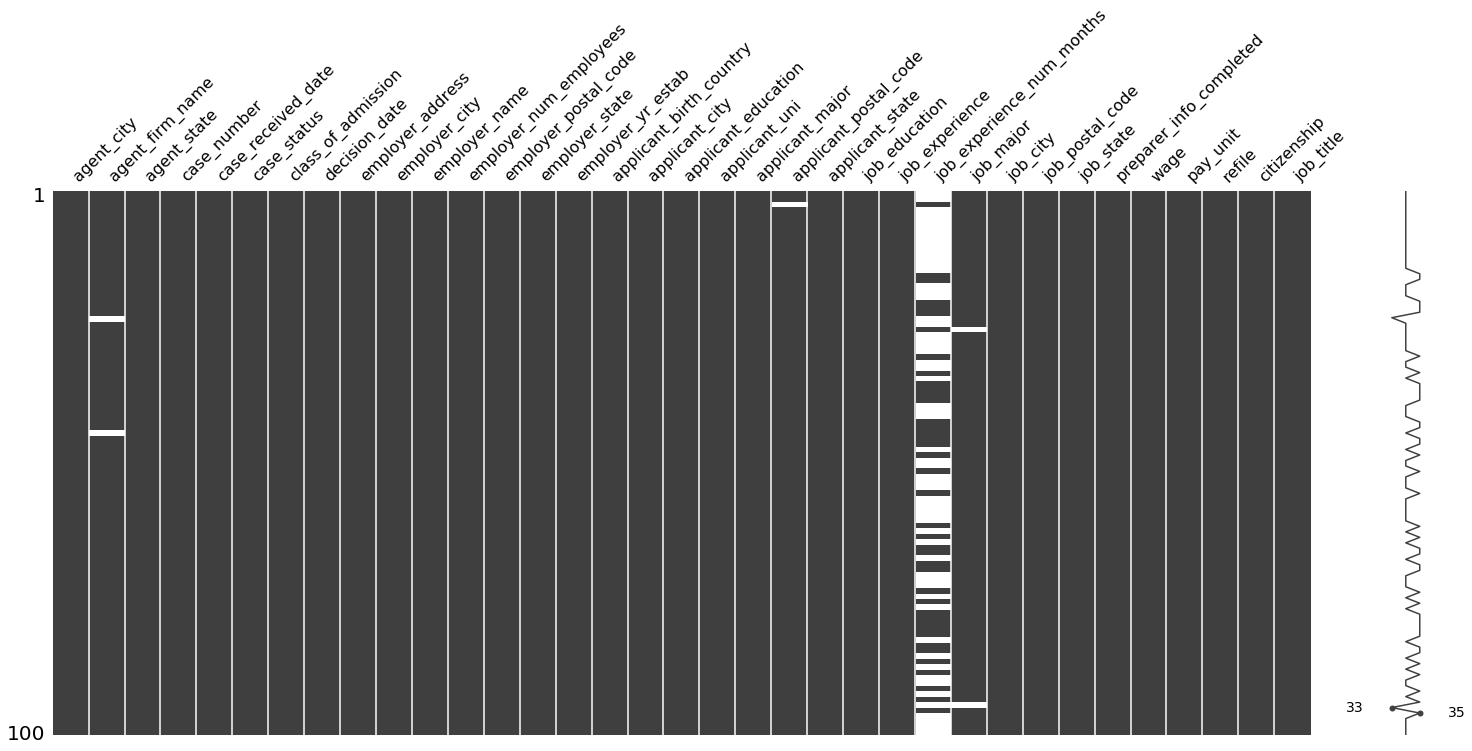

In [45]:
to_keep = pd.read_csv("lookups/to_keep.csv")
df = df.loc[:,to_keep['var_name']]
df.columns = to_keep['new_name']
msno.matrix(df.sample(100))
plt.show()

In [46]:
df.to_csv(r'data\data_cleaned.csv')